In [1]:
# supress any warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# python imports
import string

# third-party imports
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [3]:
prompt_injection_train = pd.read_csv('data/prompt_injection_train.csv')
prompt_injection_test = pd.read_csv('data/prompt_injection_test.csv')

In [4]:
X_train = prompt_injection_train['prompt']
y_train = prompt_injection_train['label']

X_test = prompt_injection_test['prompt']
y_test = prompt_injection_test['label']

## Preprocess the text data

In [5]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    # casting text to lowercase
    text = text.lower()

    # removing punctuation
    text = ''.join([word for word in text if word not in string.punctuation])

    # removing stop words
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [6]:
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

## Creating vectors

In [7]:
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [8]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

## Train a classification model

In [9]:
model_names = ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'SVC', 'MLP']
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), SVC(), MLPClassifier()]

results = dict()

for model, model_name in zip(models, model_names):        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.setdefault(model_name, {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'cm': confusion_matrix(y_test, y_pred, labels=[0, 1], normalize='true')
    })

## Results

In [10]:
data = pd.DataFrame({
    'model': model_names,
    'accuracy': [results[model_name]['accuracy'] for model_name in model_names],
    'precision': [results[model_name]['precision'] for model_name in model_names],
    'recall': [results[model_name]['recall'] for model_name in model_names],
    'f1_score': [results[model_name]['f1_score'] for model_name in model_names],
})

In [11]:
data

,model,accuracy,precision,recall,f1_score
0,LogisticRegression,0.995488,0.856502,0.634551,0.729008
1,RandomForest,0.999825,0.985222,0.996678,0.990917
2,GradientBoosting,0.996092,0.908257,0.657807,0.763006
3,SVC,0.997283,0.937120,0.767442,0.843836
4,MLP,0.999396,0.971572,0.965116,0.968333


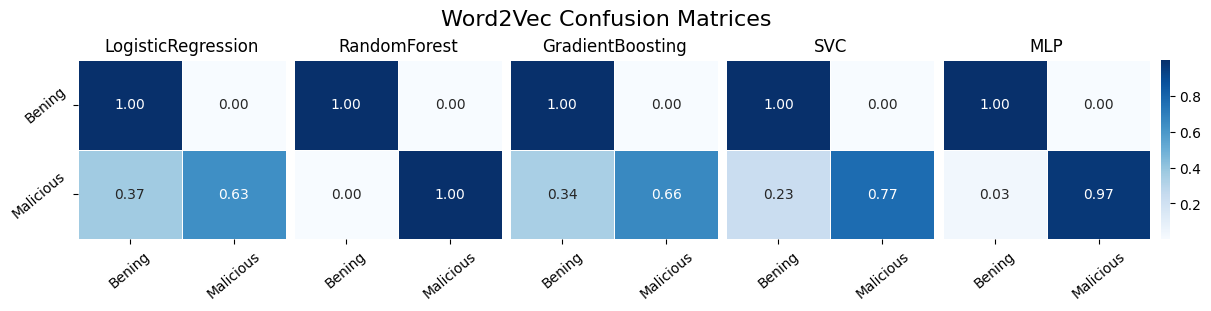

In [12]:
labels = ['Bening', 'Malicious']
titles = results.keys()
cms = [results[model_name]['cm'] for model_name in model_names]

fig, axes = plt.subplots(1, 5, figsize=(12, 3), constrained_layout=True)

fig.suptitle(f'Word2Vec Confusion Matrices', size=16)

for index, (axe, cm, title) in enumerate(zip(axes, cms, titles)):
    
    yticks = labels if index == 0 else False
    draw_cbar = True if index == 4 else False
    
    axe.set_title(title)
    axe = sns.heatmap(cm, ax=axe, annot=True, fmt=".2f", linewidths=.5, cmap=plt.cm.Blues, 
                      yticklabels=yticks, xticklabels=labels, cbar=draw_cbar)
    
    axe.set_xticklabels(axe.get_xticklabels(), rotation=40)
    axe.set_yticklabels(axe.get_yticklabels(), rotation=40)
    
plt.show()